In [ ]:
import numpy as np
import pandas as pd
import pygad
import matplotlib.pyplot as plt

# Reading the data

In [313]:
# FUNCTION TO READ THE DATA
import json

def parse(path):
    with open(path) as f:
        data = json.load(f)
        preferences = np.array(data["preferences"])
        friendships = np.array(data["friendships"])
        authorship = np.array(data["authorship"])

        # giving the info as a dictionary
        return {
            "num_papers": data["num_papers"],
            "num_reviewers": data["num_reviewers"],
            "reviewer_capacity": data["reviewer_capacity"],
            "min_reviews_per_paper": data["min_reviews_per_paper"],
            "max_reviews_per_paper": data["max_reviews_per_paper"],
            "preferences": preferences,
            "friendships": friendships,
            "authorship": authorship
        }
#reading the data        
data = parse("medium_dataset_1.json")

#saving the data in variables
num_papers = data["num_papers"]
num_reviewers = data["num_reviewers"]
reviewer_capacity = data["reviewer_capacity"]
min_reviews_per_paper = data["min_reviews_per_paper"]
max_reviews_per_paper = data["max_reviews_per_paper"],
preferences = data["preferences"]
friendships = data["friendships"]
authorship = data["authorship"] 

preferences

array([[4, 5, 5, 1, 2, 2, 2, 1, 5, 4],
       [2, 5, 5, 5, 1, 3, 2, 4, 5, 4],
       [2, 1, 4, 2, 5, 1, 3, 3, 5, 1],
       [2, 4, 3, 1, 5, 2, 3, 2, 1, 1],
       [2, 1, 4, 3, 3, 1, 3, 3, 5, 3],
       [0, 2, 4, 2, 3, 3, 5, 5, 5, 4],
       [5, 1, 3, 2, 3, 0, 1, 0, 5, 4]])

# Fitness function

In [314]:
# parameters of the genetic algorithm
number_of_generations = 40
num_parents_mating = 7
sol_per_pop = 10
generation_size = 10

In [315]:
# fittness function
def fitness_function(ga_instance, solution, solution_idx):
    solution_matrix = solution.reshape((num_reviewers, num_papers))
    return compute_preference_value(solution_matrix) - compute_penalty(solution_matrix)

def compute_preference_value(solution):
    pref_val = 0

    for reviewer in range(solution.shape[0]):
        for paper in range(solution.shape[1]):
            if solution[reviewer, paper] == 1:
                pref_val = pref_val + preferences[reviewer, paper]

    return pref_val / (solution.shape[0]*solution.shape[1]) #normalize the fitness value

def compute_penalty(solution):

    penalty = 0

    # penalty for reviewer capacity
    for reviewer in range(solution.shape[0]):
        if np.sum(solution[reviewer, :]) > reviewer_capacity:
            penalty += 15 #really high weight for capacity violations

    #penalty for the number of reviews in a paper
    for paper in range(solution.shape[1]):
        if np.sum(solution[:, paper]) > min_reviews_per_paper:
            penalty += 2 #low weight for not meeting minimum reviews
        elif np.sum(solution[:, paper]) > max_reviews_per_paper:
            penalty += 2 #low weight for not meeting minimum reviews

    #penalty for friendship using matricial operations
    for reviewer1 in range(solution.shape[0]):
        for reviewer2 in range(solution.shape[0]):
            if friendships[reviewer1,reviewer2] == 1: #they are friends
                for paper in range(solution.shape[1]):
                    if (solution[reviewer1,paper] == 1) and (solution[reviewer2,paper] == 1): #check if they review the same paper
                        penalty += 5 #high weight for friendship conflicts 

    #penalty for authory
    for reviewer in range(solution.shape[0]):
        for paper in range(solution.shape[1]):
            if solution[reviewer,paper] == 1 and (authorship[reviewer, paper]==1):
                penalty += 10 #high weight for authorship conflicts

    return penalty / (solution.shape[0]*solution.shape[1]) #normalize the fitness value

In [316]:
#try the penalty function
solution = np.random.randint(2, size=(num_reviewers, num_papers))

print("Solution:")
print(solution)
print("Penalty: ",compute_penalty(solution))

Solution:
[[1 1 1 1 0 1 0 0 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 0 0 1 0]
 [0 1 1 1 0 0 0 0 1 0]
 [0 1 0 0 1 1 0 0 0 0]
 [0 1 0 0 1 1 0 1 0 1]
 [0 1 1 0 0 0 0 1 0 0]]
Penalty:  5.5


In [317]:
#First GA
ga_instance_1 = pygad.GA(fitness_func = fitness_function,
                       num_generations = number_of_generations,
                       num_parents_mating = num_parents_mating,
                       num_genes = num_reviewers * num_papers,
                       gene_space = [0,1], #matrix with 0 and 1
                       sol_per_pop = sol_per_pop
                       )
ga_instance_1.run()

solution, solution_fitness,  solution_idx = ga_instance_1.best_solution()
solution_matrix = solution.reshape((num_reviewers, num_papers))
print("Best solution: ")
print(solution_matrix)
print("Best fitness: ", solution_fitness)

Best solution: 
[[0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1.]]
Best fitness:  0.44285714285714295


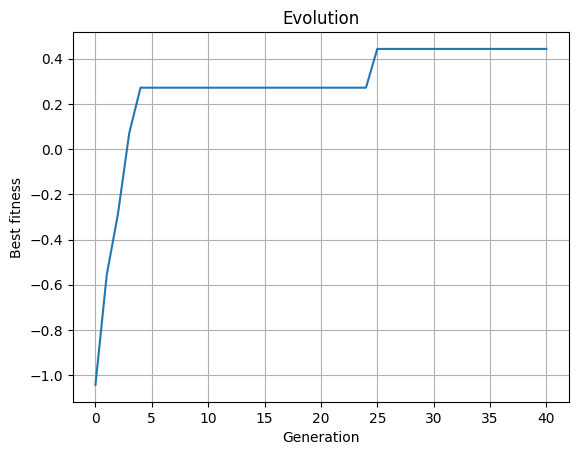

In [318]:
# Obtain and graph the best fitness per generation
fitness_per_generation = ga_instance_1.best_solutions_fitness

plt.plot(fitness_per_generation)
plt.title("Evolution")
plt.xlabel("Generation")
plt.ylabel("Best fitness")
plt.grid()
plt.show()

# Crossover and mutation function

In [319]:
#Crossover funtion
def custom_crossover(parents, offspring_size, ga_instance):
    
    offspring = []
    while len(offspring) < offspring_size[0]:

        # finding random parents
        parents_split = np.vsplit(parents, parents.shape[0])
        potparents_idx = np.random.choice(parents.shape[0], size=2, replace=False)
        potparents = np.array([parents_split[potparents_idx[0]], parents_split[potparents_idx[1]]]).reshape(2, num_reviewers, num_papers)       

        # crossing parents
        child = np.zeros(offspring_size[1]).reshape(num_reviewers, num_papers)
        
        for i in range(child.shape[1]):
            parentidx = np.random.randint(0, 2)
            parent = potparents[parentidx]
            otherParent = potparents[(parentidx - 1) % 2]

            if check_colum(parent[:, i], i):
                extend_child_valid(child, parent[:, i], i)
            elif check_colum(otherParent[:, i], i):
                extend_child_valid(child, otherParent[:, i], i)
            else:
                # add no restictions if no parents match
                child[:, i] = np.zeros(num_reviewers)
                
        offspring.append(child.reshape(offspring_size[1]))

    return np.array(offspring)


def check_colum(colum, index):
    # check rev per paper
    if max_reviews_per_paper < np.sum(colum) < min_reviews_per_paper:
        return False
    
    # check authorship
    for i in range(colum.shape[0]):

        if colum[i] == 1:
            if authorship[i, index] == 1:
                return False
            
    # check friendships
    for i in range(colum.shape[0]):
        for j in range(colum.shape[0]):
            if i != j:
                if colum[i] == 1 and colum[j] == 1:
                    if friendships[i, j] == 1:
                        return False
    
    return True


def extend_child_valid(child, extend, index):

    # reviewer_capacity has to be considered
    current_rev_max = np.max(child.sum(axis=1))
    current_rev_idx = child.sum(axis=1).argmax()
    if check_colum(extend, index) and current_rev_max + extend[current_rev_idx] < reviewer_capacity:
       child[:, index] = extend
    else:
        # add no restictions if no parents match
        child[:, index] = np.zeros_like(extend)

In [320]:
#GA with custom crossover
ga_instance_2 = pygad.GA(fitness_func = fitness_function,
                       num_generations = number_of_generations,
                       num_parents_mating = num_parents_mating,
                       num_genes = num_reviewers * num_papers,
                       gene_space = [0,1],
                       sol_per_pop = sol_per_pop,
                       crossover_type = custom_crossover
                       )
ga_instance_2.run()

solution, solution_fitness,  solution_idx = ga_instance_2.best_solution()
solution_matrix = solution.reshape((num_reviewers, num_papers))
print("Best solution: ")
print(solution_matrix)
print("Best fitness: ", solution_fitness)

Best solution: 
[[0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]]
Best fitness:  0.9000000000000001


In [321]:
def custom_mutation(solution, ga_instance):
    custom_rate = 0.1
    
    for i in range(len(solution)):
        for j in range(len(solution[i])):
            if np.random.rand() < custom_rate:          
                solution_fitness = fitness_function(ga_instance, solution[i],0)

                solution[i][j] = 1 - solution[i][j]
                muted_solution_fitness = fitness_function(ga_instance, solution[i],0)

                if muted_solution_fitness < solution_fitness:
                    solution[i][j] = 1 - solution[i][j]
    return solution

In [322]:
#GA with custom mutation
ga_instance_3 = pygad.GA(fitness_func = fitness_function,
                       num_generations = number_of_generations,
                       num_parents_mating = num_parents_mating,
                       num_genes = num_reviewers * num_papers,
                       gene_space = [0,1],
                       sol_per_pop = sol_per_pop,
                       crossover_type=custom_crossover,
                       mutation_type=custom_mutation                     
                    )
ga_instance_3.run()

solution, solution_fitness,  solution_idx = ga_instance_3.best_solution()
solution_matrix = solution.reshape((num_reviewers, num_papers))
print("Best solution: ")
print(solution_matrix)
print("Best fitness: ", solution_fitness)

Best solution: 
[[1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 1. 1.]
 [1. 1. 0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 1. 1. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 0. 0. 1. 1.]]
Best fitness:  1.2571428571428573


In [323]:
#GA with custom crossover and mutation
ga_instance_4 = pygad.GA(fitness_func = fitness_function,
                       num_generations = number_of_generations,
                       num_parents_mating = num_parents_mating,
                       num_genes = num_reviewers * num_papers,
                       gene_space = [0,1],
                       sol_per_pop = sol_per_pop,
                       crossover_type=custom_crossover,
                       mutation_type=custom_mutation                     
                    )
ga_instance_4.run()

solution, solution_fitness,  solution_idx = ga_instance_4.best_solution()
solution_matrix = solution.reshape((num_reviewers, num_papers))
print("Best solution: ")
print(solution_matrix)
print("Best fitness: ", solution_fitness)

Best solution: 
[[1. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 1. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 1. 1.]
 [0. 1. 1. 0. 0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0. 0. 1. 0. 1. 1.]]
Best fitness:  1.4


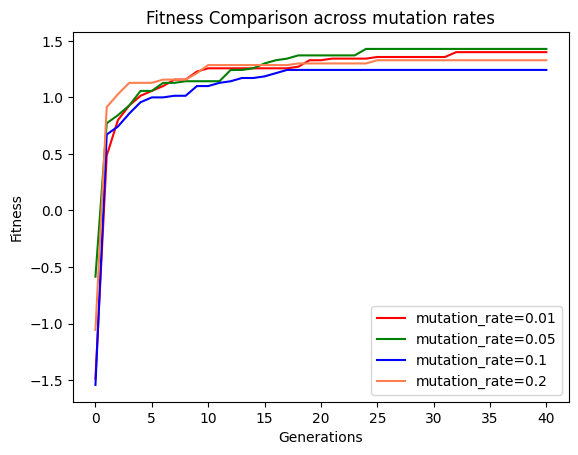

In [324]:
#compare different custom rates for the mutation
mutation_rates = [0.01, 0.05, 0.1, 0.2]
mutation_results = []
mutation_titles = []

for custom_rate in mutation_rates:
    # calculating the fitness for each custom_rate
    ga_instance = pygad.GA(fitness_func = fitness_function,
                        num_generations = number_of_generations,
                        num_parents_mating = num_parents_mating,
                        num_genes = num_reviewers * num_papers,
                        gene_space = [0,1],
                        sol_per_pop = sol_per_pop,
                        crossover_type=custom_crossover,
                        mutation_type=custom_mutation                     
                        )
    ga_instance.run()
    solution, solution_fitness,  solution_idx = ga_instance.best_solution()
    mutation_results.append(ga_instance.best_solutions_fitness)
    mutation_titles.append(f"mutation_rate={custom_rate}")

plt.plot(mutation_results[0],color='r',label=mutation_titles[0])
plt.plot(mutation_results[1],color='g',label=mutation_titles[1])
plt.plot(mutation_results[2],color='b',label=mutation_titles[2])
plt.plot(mutation_results[3],color='coral',label=mutation_titles[3])
plt.legend()
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title("Fitness Comparison across mutation rates")

plt.show()


At least for the "medium_dataset_1.json" the mutation rate that fits best is 0.1

# Different parameters

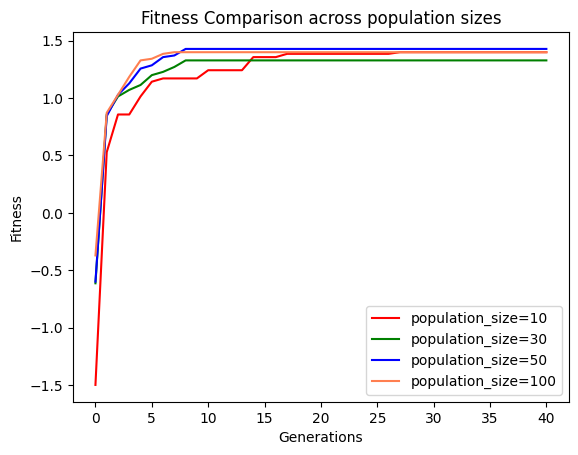

In [325]:
# Compare different population sizes 
population_sizes = [10,30,50,100]
population_results = []
population_titles=[]

for size in population_sizes:
    # calculating the fitness for each dataset
    ga_instance = pygad.GA(fitness_func = fitness_function,
                        num_generations = number_of_generations,
                        num_parents_mating = num_parents_mating,
                        num_genes = num_reviewers * num_papers,
                        gene_space = [0,1],
                        sol_per_pop = size, #population size
                        crossover_type=custom_crossover,
                        mutation_type=custom_mutation                     
                        )
    ga_instance.run()
    solution, solution_fitness,  solution_idx = ga_instance.best_solution()
    population_results.append(ga_instance.best_solutions_fitness)
    population_titles.append(f"population_size={size}")

plt.plot(population_results[0],color='r',label=population_titles[0])
plt.plot(population_results[1],color='g',label=population_titles[1])
plt.plot(population_results[2],color='b',label=population_titles[2])
plt.plot(population_results[3],color='coral',label=population_titles[3])
plt.legend()
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title("Fitness Comparison across population sizes")

plt.show()

The best population size for "medium_dataset_1.json" is 50

In [326]:
sol_per_pop = 50

# Different crossover functions

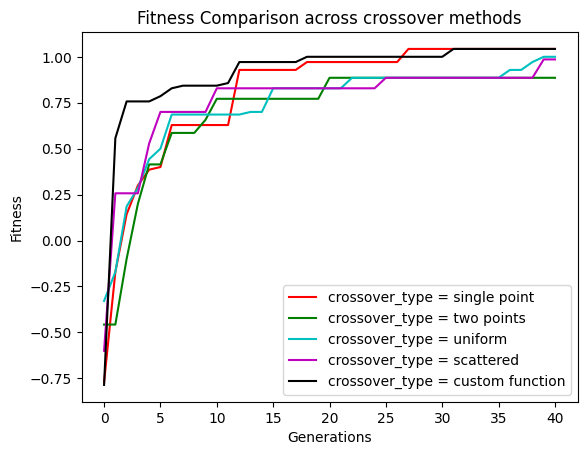

In [327]:
crossover_functions = ["single_point", "two_points", "uniform", "scattered", custom_crossover]
crossover_results = []

for crossover in crossover_functions:
    # calculating the fitness for each dataset
    ga_instance = pygad.GA(fitness_func = fitness_function,
                        num_generations = number_of_generations,
                        num_parents_mating = num_parents_mating,
                        num_genes = num_reviewers * num_papers,
                        gene_space = [0,1],
                        sol_per_pop = sol_per_pop,
                        crossover_type=crossover                     
                        )
    ga_instance.run()
    solution, solution_fitness,  solution_idx = ga_instance.best_solution()
    crossover_results.append(ga_instance.best_solutions_fitness)

plt.plot(crossover_results[0],color='r',label="crossover_type = single point")
plt.plot(crossover_results[1],color='g',label="crossover_type = two points")
plt.plot(crossover_results[2],color='c',label="crossover_type = uniform")
plt.plot(crossover_results[3],color='m',label="crossover_type = scattered")
plt.plot(crossover_results[4],color='k',label="crossover_type = custom function")
plt.legend()
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title("Fitness Comparison across crossover methods")

plt.show()

The best crossover function is our custom function as it also converges way quicker to the higher end value.

# Different configurations

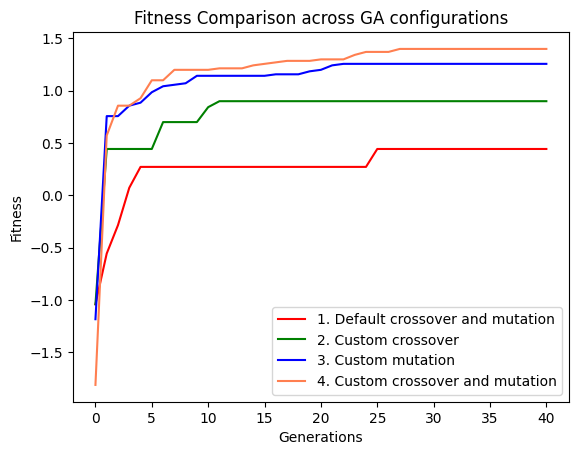

In [328]:
#Fitness evolution with different crossover or mutation functions
results = np.array([ga_instance_1.best_solutions_fitness,
                    ga_instance_2.best_solutions_fitness,
                    ga_instance_3.best_solutions_fitness,
                    ga_instance_4.best_solutions_fitness])

titles = ["1. Default crossover and mutation",
          "2. Custom crossover",
          "3. Custom mutation",
          "4. Custom crossover and mutation"]

plt.plot(results[0],color='r',label=titles[0])
plt.plot(results[1],color='g',label=titles[1])
plt.plot(results[2],color='b',label=titles[2])
plt.plot(results[3],color='coral',label=titles[3])
plt.legend()
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title("Fitness Comparison across GA configurations")

plt.show()


The graph illustrates the fitness evolution of different configurations of a Genetic Algorithm (GA). The fixed carachteristics are:

Number of generations = 40  
Number of parents mating = 5  
Solution per population = 10  
Generation size = 10

What varies between configurations are the crossover and the mutation function. Based on the fitness, the graph clearly shows that the combination of custom crossover and mutation (orange line) is the most effective configuration for this problem.



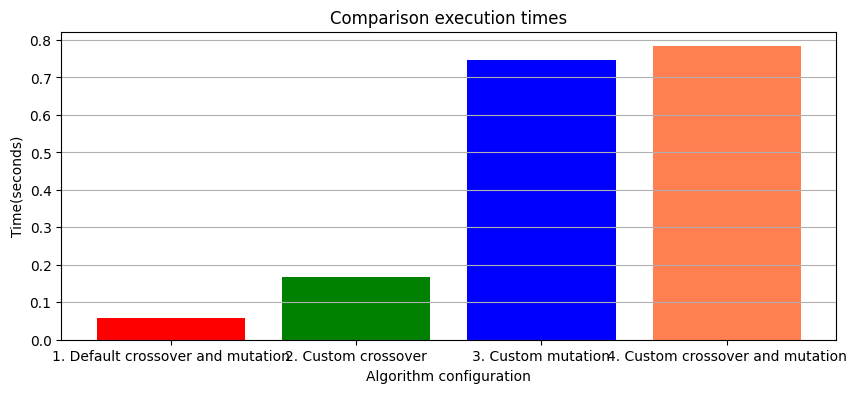

In [329]:
# execution time
import time

execution_times = []
for config in [ga_instance_1, ga_instance_2, ga_instance_3, ga_instance_4]:
    start_time = time.time()
    config.run()
    execution_times.append(time.time()-start_time)

plt.figure(figsize=(10,4))
plt.bar(titles, execution_times, color=["r","g","b","coral"])
plt.title("Comparison execution times")
plt.xlabel("Algorithm configuration")
plt.ylabel("Time(seconds)")
plt.grid(axis="y")

plt.show()

# Different datasets

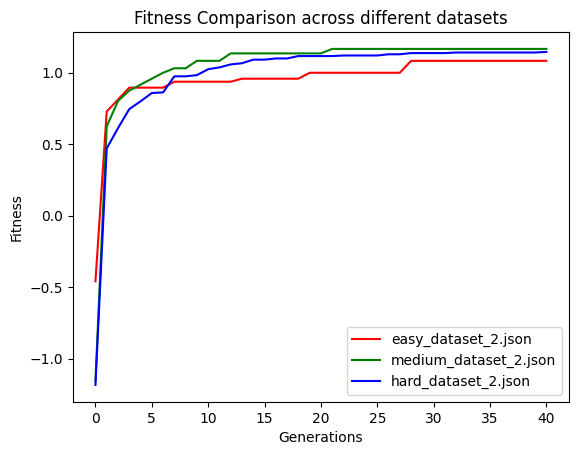

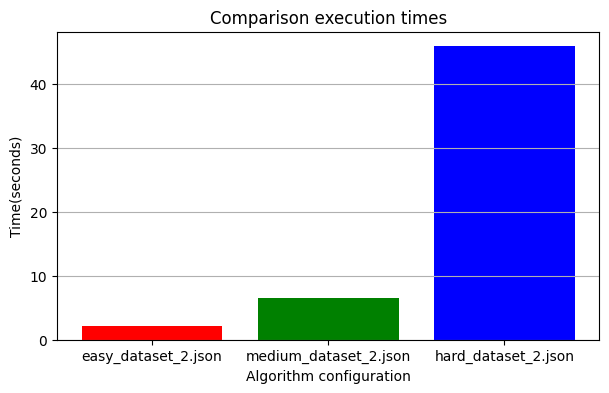

In [330]:
paths = np.array(["easy_dataset_2.json","medium_dataset_2.json","hard_dataset_2.json"])

results_datasets = []
titles_datasets = []
execution_times_datasets = []
for path in paths:
    #reading the data        
    data = parse(path)

    #saving the data in variables
    num_papers = data["num_papers"]
    num_reviewers = data["num_reviewers"]
    reviewer_capacity = data["reviewer_capacity"]
    min_reviews_per_paper = data["min_reviews_per_paper"]
    max_reviews_per_paper = data["max_reviews_per_paper"],
    preferences = data["preferences"]
    friendships = data["friendships"]
    authorship = data["authorship"]

    # calculating the fitness for each dataset
    ga_instance = pygad.GA(fitness_func = fitness_function,
                        num_generations = number_of_generations,
                        num_parents_mating = num_parents_mating,
                        num_genes = num_reviewers * num_papers,
                        gene_space = [0,1],
                        sol_per_pop = sol_per_pop,
                        crossover_type=custom_crossover,
                        mutation_type=custom_mutation                     
                        )
    start_time = time.time() #to measure the execution time
    ga_instance.run()
    execution_times_datasets.append(time.time()-start_time)
    solution, solution_fitness,  solution_idx = ga_instance.best_solution()

    results_datasets.append(ga_instance.best_solutions_fitness)
    titles_datasets.append(path)
    

plt.plot(results_datasets[0],color='r',label=titles_datasets[0])
plt.plot(results_datasets[1],color='g',label=titles_datasets[1])
plt.plot(results_datasets[2],color='b',label=titles_datasets[2])
plt.legend()
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title("Fitness Comparison across different datasets")
plt.show()

plt.figure(figsize=(7,4))
plt.bar(titles_datasets, execution_times_datasets, color=["r","g","b"])
plt.title("Comparison execution times")
plt.xlabel("Algorithm configuration")
plt.ylabel("Time(seconds)")
plt.grid(axis="y")
plt.show()


The first graph shows the evolution of the best fitness of three different datasets over 40 generations and the second one compares the time each dataset takes. The "easy" dataset converges quickly to a high fitness value while the "medium"'s and "hard"'s evolution is slower and the final fitness value is lower for the hard dataset. This demonstrates that the complexity of the problem affects directly to the performance of the algorithm, as more generations and execution time is needed to find the optimal solution. In cojunction with the optimasations of this algorithm to a medium dataset these results make sense.